# Time Trends Analysis

This notebook analyzes temporal patterns in job postings to identify seasonal hiring trends and market patterns over time.

## Business Question:
**What are the temporal patterns in job postings? Are there seasonal hiring trends or market patterns over time?**

This analysis will help identify:
- Monthly posting volume trends
- Seasonal hiring patterns
- Market activity fluctuations over time

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os
from pathlib import Path
from datetime import datetime

# Add sql directory to path for database utilities
sys.path.append('../sql')
from database_setup import DatabaseManager

# Configure display and warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create charts directory if it doesn't exist
charts_dir = Path('../assets/charts')
charts_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")
print(f"Charts will be saved to: {charts_dir.absolute()}")

Libraries imported successfully
Charts will be saved to: c:\Users\hp\Downloads\wuzuf-analysis\notebooks\..\assets\charts


In [2]:
# Initialize database connection
print("Connecting to PostgreSQL database...")

try:
    db_manager = DatabaseManager()
    engine = db_manager.get_engine()
    
    # Test connection
    status = db_manager.test_connection()
    print(f"✅ Connected to database: {status['database']}")
    print(f"📊 Tables available: {status['table_count']}")
    
except Exception as e:
    print(f"❌ Database connection failed: {e}")
    print("Please ensure PostgreSQL is running and database is set up correctly")
    raise

2025-08-15 01:45:19,521 - INFO - Database connection established successfully


Connecting to PostgreSQL database...
✅ Connected to database: wuzzuf
📊 Tables available: 6


## Time Trends Analysis

Analyzing temporal patterns in job postings to identify seasonal hiring trends and market patterns over time.

In [3]:
# First, let's check what data we have for time analysis
data_check_query = """
SELECT 
    MIN(posting_date) as earliest_date,
    MAX(posting_date) as latest_date,
    COUNT(*) as total_jobs,
    COUNT(DISTINCT posting_year) as unique_years,
    COUNT(DISTINCT posting_month) as unique_months
FROM jobs 
WHERE posting_date IS NOT NULL;
"""

data_overview = pd.read_sql_query(data_check_query, engine)
print("📅 Data Overview:")
display(data_overview)

📅 Data Overview:


,earliest_date,latest_date,total_jobs,unique_years,unique_months
0,2017-01-01,2021-12-31,25114,5,12


In [9]:
# SQL query for monthly posting volume trends (limited to 10 rows as per requirements)
time_trends_query = """
SELECT 
    posting_year,
    posting_month,
    COUNT(*) as posting_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
FROM jobs 
WHERE posting_year IS NOT NULL 
    AND posting_month IS NOT NULL
GROUP BY posting_year, posting_month
ORDER BY posting_count DESC
LIMIT 10;
"""

print("📊 SQL Query for Time Trends Analysis:")
print(time_trends_query)

📊 SQL Query for Time Trends Analysis:

SELECT 
    posting_year,
    posting_month,
    COUNT(*) as posting_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
FROM jobs 
WHERE posting_year IS NOT NULL 
    AND posting_month IS NOT NULL
GROUP BY posting_year, posting_month
ORDER BY posting_count DESC
LIMIT 10;



In [10]:
# Execute query and get results
time_trends_df = pd.read_sql_query(time_trends_query, engine)

print("📈 Time Trends Analysis Results:")
print(f"Total periods analyzed: {len(time_trends_df)}")
print("\n🔝 Top 10 months by posting volume:")
display(time_trends_df)

📈 Time Trends Analysis Results:
Total periods analyzed: 10

🔝 Top 10 months by posting volume:


,posting_year,posting_month,posting_count,percentage
0,2020,6,963,3.83
1,2021,3,945,3.76
2,2021,2,933,3.72
3,2020,7,886,3.53
4,2021,6,876,3.49
5,2020,5,814,3.24
6,2020,8,807,3.21
7,2021,12,753,3.00
8,2020,9,692,2.76
9,2021,11,673,2.68


In [12]:
# Get complete time series data for visualization - CORRECTED VERSION
complete_trends_query = """
SELECT 
    posting_year,
    posting_month,
    COUNT(*) as posting_count
FROM jobs 
WHERE posting_year IS NOT NULL 
    AND posting_month IS NOT NULL
GROUP BY posting_year, posting_month
ORDER BY posting_year, posting_month;
"""

complete_trends_df = pd.read_sql_query(complete_trends_query, engine)

# Create a proper date column for plotting - FIXED VERSION
# Rename columns to match pandas to_datetime expectations
date_df = complete_trends_df[['posting_year', 'posting_month']].copy()
date_df = date_df.rename(columns={'posting_year': 'year', 'posting_month': 'month'})
date_df['day'] = 1
complete_trends_df['date'] = pd.to_datetime(date_df)
complete_trends_df['year_month'] = complete_trends_df['date'].dt.strftime('%Y-%m')

print(f"📊 Complete time series data: {len(complete_trends_df)} periods")
print(f"📅 Date range: {complete_trends_df['date'].min()} to {complete_trends_df['date'].max()}")
display(complete_trends_df.head())


📊 Complete time series data: 60 periods
📅 Date range: 2017-01-01 00:00:00 to 2021-12-01 00:00:00


,posting_year,posting_month,posting_count,date,year_month
0,2017,1,264,2017-01-01,2017-01
1,2017,2,190,2017-02-01,2017-02
2,2017,3,249,2017-03-01,2017-03
3,2017,4,239,2017-04-01,2017-04
4,2017,5,234,2017-05-01,2017-05


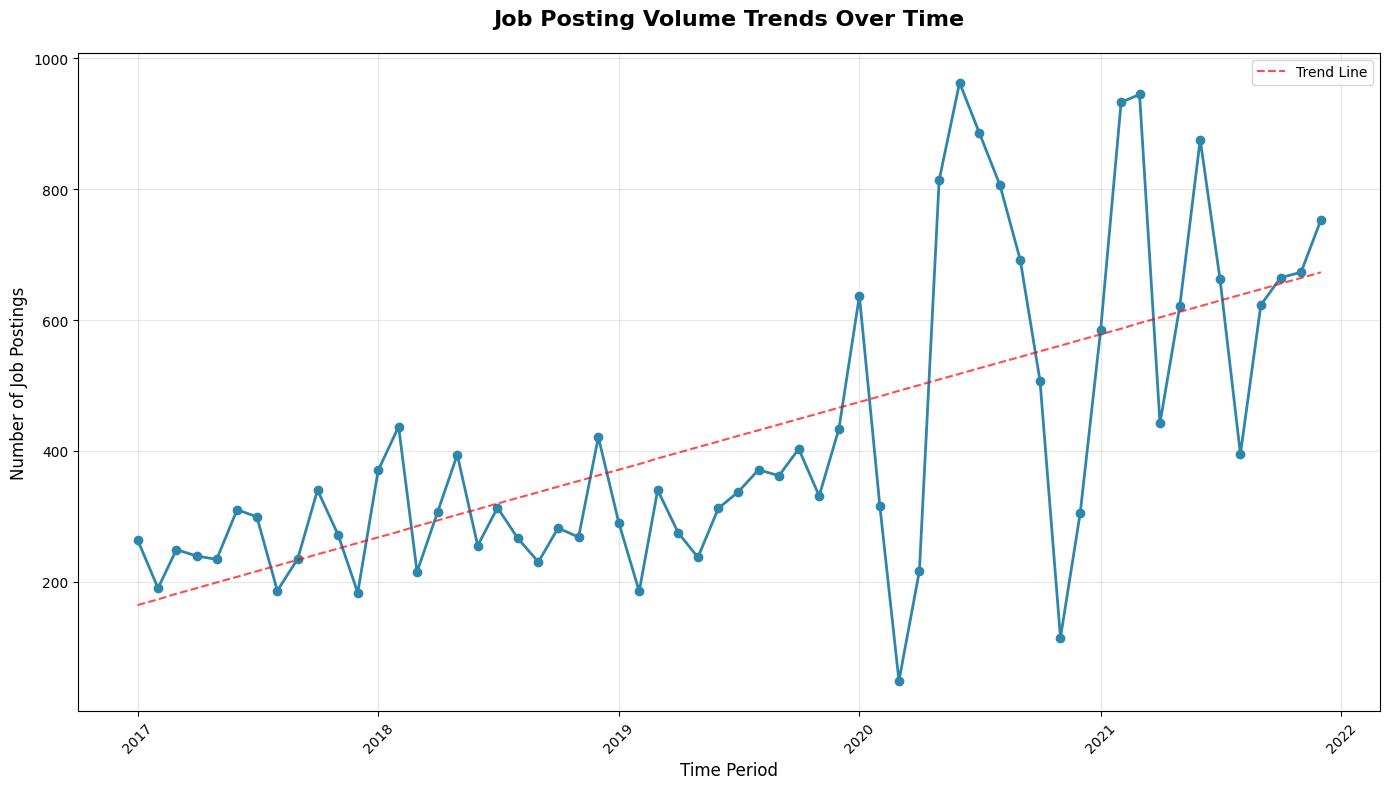

💾 Time trends chart saved to ..\assets\charts\time_trends.png


In [13]:
# Create time trends visualization
plt.figure(figsize=(14, 8))

# Line chart for time trends
plt.plot(complete_trends_df['date'], complete_trends_df['posting_count'], 
         marker='o', linewidth=2, markersize=6, color='#2E86AB')

plt.title('Job Posting Volume Trends Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Number of Job Postings', fontsize=12)

# Format x-axis
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add trend line if we have enough data points
if len(complete_trends_df) > 1:
    z = np.polyfit(range(len(complete_trends_df)), complete_trends_df['posting_count'], 1)
    p = np.poly1d(z)
    plt.plot(complete_trends_df['date'], p(range(len(complete_trends_df))), 
             "--", alpha=0.7, color='red', label='Trend Line')
    plt.legend()

plt.tight_layout()

# Save the chart
chart_path = charts_dir / 'time_trends.png'
plt.savefig(chart_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Time trends chart saved to {chart_path}")

In [14]:
# Additional seasonal analysis
seasonal_analysis_query = """
SELECT 
    posting_month,
    COUNT(*) as total_postings,
    ROUND(AVG(COUNT(*)) OVER(), 0) as avg_monthly_postings,
    CASE 
        WHEN posting_month IN (12, 1, 2) THEN 'Winter'
        WHEN posting_month IN (3, 4, 5) THEN 'Spring'
        WHEN posting_month IN (6, 7, 8) THEN 'Summer'
        WHEN posting_month IN (9, 10, 11) THEN 'Fall'
    END as season
FROM jobs 
WHERE posting_month IS NOT NULL
GROUP BY posting_month
ORDER BY posting_month;
"""

seasonal_df = pd.read_sql_query(seasonal_analysis_query, engine)
print("🌍 Seasonal Posting Patterns:")
display(seasonal_df)

🌍 Seasonal Posting Patterns:


,posting_month,total_postings,avg_monthly_postings,season
0,1,2146,2093.0,Winter
1,2,2061,2093.0,Winter
2,3,1797,2093.0,Spring
3,4,1478,2093.0,Spring
4,5,2300,2093.0,Spring
5,6,2716,2093.0,Summer
6,7,2498,2093.0,Summer
7,8,2025,2093.0,Summer
8,9,2142,2093.0,Fall
9,10,2197,2093.0,Fall


## Business Insights

Based on the time trends analysis:

In [15]:
# Calculate key metrics for insights
total_postings = complete_trends_df['posting_count'].sum()
avg_monthly_postings = complete_trends_df['posting_count'].mean()
peak_month = complete_trends_df.loc[complete_trends_df['posting_count'].idxmax()]
lowest_month = complete_trends_df.loc[complete_trends_df['posting_count'].idxmin()]

print("🔍 KEY INSIGHTS:")
print("=" * 50)
print(f"📈 Peak hiring month: {peak_month['year_month']} with {peak_month['posting_count']:,} postings")
print(f"📉 Lowest activity month: {lowest_month['year_month']} with {lowest_month['posting_count']:,} postings")
print(f"📊 Average monthly postings: {avg_monthly_postings:,.0f}")
print(f"📅 Total periods analyzed: {len(complete_trends_df)} months")
print(f"📋 Total job postings: {total_postings:,}")

# Calculate trend direction if we have enough data
if len(complete_trends_df) > 1:
    z = np.polyfit(range(len(complete_trends_df)), complete_trends_df['posting_count'], 1)
    trend_slope = z[0]
    trend_direction = "increasing" if trend_slope > 0 else "decreasing" if trend_slope < 0 else "stable"
    print(f"📈 Overall trend: {trend_direction} over the analyzed period")

print("\n🌍 SEASONAL INSIGHTS:")
print("=" * 50)

# Seasonal insights
if not seasonal_df.empty:
    seasonal_summary = seasonal_df.groupby('season')['total_postings'].sum().sort_values(ascending=False)
    print(f"🔥 Most active season: {seasonal_summary.index[0]} with {seasonal_summary.iloc[0]:,} total postings")
    print(f"❄️ Least active season: {seasonal_summary.index[-1]} with {seasonal_summary.iloc[-1]:,} total postings")
    
    # Show all seasons
    print("\n📊 Posting volume by season:")
    for season, count in seasonal_summary.items():
        percentage = (count / seasonal_summary.sum()) * 100
        print(f"   {season}: {count:,} postings ({percentage:.1f}%)")

🔍 KEY INSIGHTS:
📈 Peak hiring month: 2020-06 with 963 postings
📉 Lowest activity month: 2020-03 with 48 postings
📊 Average monthly postings: 419
📅 Total periods analyzed: 60 months
📋 Total job postings: 25,114
📈 Overall trend: increasing over the analyzed period

🌍 SEASONAL INSIGHTS:
🔥 Most active season: Summer with 7,239 total postings
❄️ Least active season: Spring with 5,575 total postings

📊 Posting volume by season:
   Summer: 7,239 postings (28.8%)
   Winter: 6,303 postings (25.1%)
   Fall: 5,997 postings (23.9%)
   Spring: 5,575 postings (22.2%)


In [16]:
# Close database connection
try:
    db_manager.close()
    print("\n🔌 Database connection closed successfully.")
except:
    print("\n⚠️ Database connection was already closed.")

2025-08-15 01:49:30,490 - INFO - Database connections closed



🔌 Database connection closed successfully.
